<a href="https://colab.research.google.com/github/willschlitzer/fastai_lessons/blob/main/digit_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai
!pip install fastbook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 719 kB 7.3 MB/s 
     |████████████████████████████████| 365 kB 26.5 MB/s 
     |████████████████████████████████| 1.3 MB 13.7 MB/s 
     |████████████████████████████████| 4.7 MB 22.7 MB/s 
     |████████████████████████████████| 115 kB 38.2 MB/s 
     |████████████████████████████████| 120 kB 46.8 MB/s 
     |████████████████████████████████| 212 kB 36.8 MB/s 
     |████████████████████████████████| 127 kB 23.4 MB/s 
     |████████████████████████████████| 6.6 MB 37.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
from fastbook import *
from fastai.vision.all import *

In [3]:
# Get MNIST samples
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/labels.csv')]

In [5]:
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/3'),Path('/root/.fastai/data/mnist_sample/train/7')]

In [6]:
# Create a list of the png files for 3 and 7
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [7]:
# Open an image in the "3" category
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

numpy array of the image




In [8]:
# Display a portion of the image as a numpy array
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [9]:
# Create a dataframe from a tensor of the image
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


Create tensor images of the average pixel values of all images

In [10]:
# Create a list of tensors for the 3 and 7 images
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]
len(three_tensors), len(seven_tensors)


(6131, 6265)

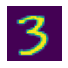

In [11]:
show_image(three_tensors[1])

In [12]:
# Stack all of the tensors to get an average value
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

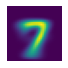

In [13]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

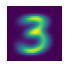

In [14]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

In [15]:
# Perform a loss function to determine if 3 is closer to the ideal 7 or 3
a_3 = stacked_threes[1]
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [16]:
# Import and stack the valid data
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [17]:
# Function to see how inputs are from one another
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [18]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1541, 0.1522, 0.1262,  ..., 0.1621, 0.1411, 0.1183]),
 torch.Size([1010]))

Test if a function is a 3

In [19]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [20]:
# Test on a single 3 image
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [21]:
# Perform 3 check on all valid 3s
is_3(valid_3_tens)

tensor([ True, False,  True,  ...,  True,  True,  True])

In [22]:
# Check accuracy on valid 3
accuracy_3s = is_3(valid_3_tens).float().mean()
# Check accuraacy on valid 7
accuracy_7s = (1 - is_3(valid_7_tens).float().mean())
accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

Stochastic Gradient Descent

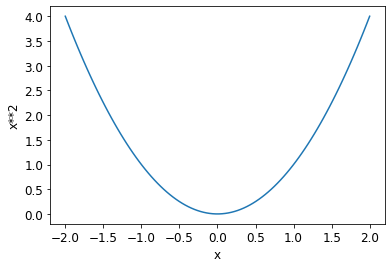

In [23]:
def f(x): return x**2
plot_function(f, 'x', 'x**2')

In [24]:
xt = tensor(3.).requires_grad_()

In [25]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [26]:
yt.backward()

In [27]:
xt.grad

tensor(6.)

In [28]:
xt = tensor([3., 4., 10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [29]:
def f(x): return (x**2).sum()
yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [30]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

In [31]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

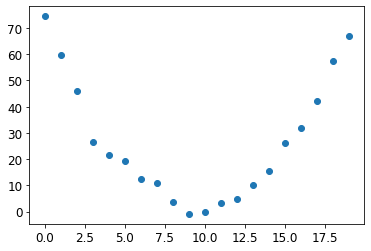

In [32]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed)

In [33]:
def f(t, params):
  a,b,c = params
  return a*(t**2) + (b*t) + c

In [34]:
def mse(preds, targets): return ((preds-targets)**2).mean()

Initialize parameters

In [35]:
params = torch.randn(3).requires_grad_(); params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

Calculate predictions

In [36]:
preds = f(time, params)

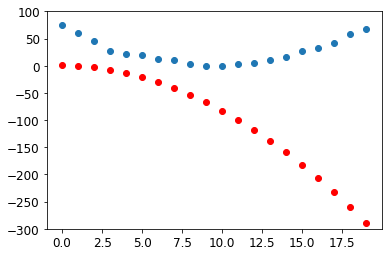

In [37]:
def show_preds(preds, ax=None):
  if ax is None: ax = plt.subplots()[1]
  ax.scatter(time, speed)
  ax.scatter(time, to_np(preds), color="red")
  ax.set_ylim(-300, 100)

show_preds(preds)

Calculate the loss

In [38]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

Calculate the gradients

In [39]:
loss.backward()
params.grad

tensor([-53195.8633,  -3419.7148,   -253.8908])

In [40]:
params.grad * 1e-5

tensor([-0.5320, -0.0342, -0.0025])

In [41]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

Step the weights

In [42]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [43]:
preds = f(time, params)
mse(preds, speed)

tensor(5435.5356, grad_fn=<MeanBackward0>)

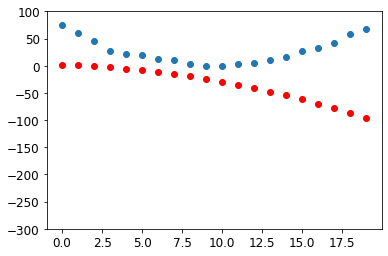

In [44]:
show_preds(preds)

In [45]:
def apply_step(params, prn=True):
  preds = f(time, params)
  loss = mse(preds, speed)
  loss.backward()
  params.data -= lr * params.grad.data
  params.grad = None
  if prn: print(loss.item())
  return preds

In [46]:
for i in range(10):apply_step(params)

5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812
677.0023803710938
676.9645385742188
676.9537353515625


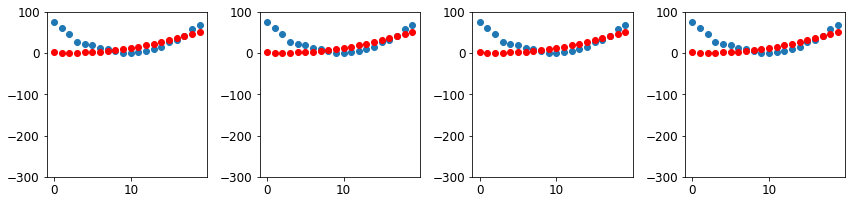

In [47]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

MNIST Loss Function

In [79]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*len(threes)+[0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [80]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [81]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [82]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
weights = init_params((28*28,1))
bias = init_params(1)

In [83]:
(train_x[0]*weights.T).sum() + bias

tensor([-15.0616], grad_fn=<AddBackward0>)

Matrix multiplication

In [84]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[-15.0616],
        [-14.2255],
        [-14.3161],
        ...,
        [  4.1170],
        [  6.6990],
        [ -4.7197]], grad_fn=<AddBackward0>)

In [91]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [ True]])

In [93]:
corrects.float().mean().item()

0.38520491123199463

In [92]:
weight_clone = weights[0].clone()
weight_clone *= 1.0001
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.38520491123199463

In [98]:
def mnist_loss(predictions, targets):
  """If target==1, returns how far from 1 the prediction is, else returns how far it is from 0"""
  return torch.where(targets==1, 1-predictions, predictions).mean()

In [96]:
trgts = tensor([1,0,1])
prds = tensor([0.9, 0.4, 0.2])
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [97]:
mnist_loss(prds, trgts)

tensor(0.4333)

Sigmoid